# Exploration of Bay Wheels ride data from August 2021
## by Elaine Chow

## Investigation Overview

> In this investigation, I explored Bay Wheels bike sharing data from August 2021. The main focus to look at  were trends or patterns in ride duration (in minutes),  ride distance (from starting point to ending point, not by route) and  estimated ride cost, by rider type and by bike type. I also examined this data to see if there were trends or patterns depending on time: the start hour, the day of the week and the day of the month (i.e., what did the ride data look like over the entire month). 

## Dataset Overview

> The cleaned dataset consisted of attributes of approximately 202,655 Bay Wheels rides, including with bike type, rider type, start date/time, end date/time, ride duration, start latitude, start longitude, end latitude, end longitude, start_datehour, end_date_hour, start_dayofweek, end_dayofweek, dist_in_km, est_ride_cost). 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv("/users/elainechow/downloads/202108-baywheels-tripdata.csv")

In [3]:
#make a copy to work on
df_clean = df.copy()

In [4]:
#rename columns
df_clean.rename(columns={"rideable_type": "bike_type", "member_casual": "rider_type"}, inplace=True) 

In [5]:
df_clean["bike_type"] = df_clean["bike_type"].astype('category')

In [6]:
df_clean["rider_type"] = df_clean["rider_type"].astype('category')

In [7]:
df_clean = df_clean[df_clean["end_lat"].notnull()]

In [8]:
values = {"start_station_name": "Unavailable", "start_station_id": "Unavailable", "end_station_name": "Unavailable", "end_station_id": "Unavailable"}
df_clean.fillna(value=values, inplace=True)

In [9]:
#convert "started_at" to datetime object
from datetime import datetime

df_clean['started_at'] = df_clean['started_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


In [10]:
#convert "ended_at" to datetime object
df_clean['ended_at'] = df_clean['ended_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


In [11]:
#create a new column, "ride_duration", which is the difference in minutes 
#between ended_at and started_at
from dateutil.relativedelta import relativedelta
from datetime import date

#calculate the difference in minutes between when a ride started and when it ended.
df_clean["ride_duration"] = df_clean['ended_at'] - df_clean['started_at']
df_clean["ride_duration"]=df_clean["ride_duration"]/np.timedelta64(1,'m')


In [12]:
#rearrange the columns to move ride_duration closer to "started_at"
cols = ['ride_id', 'bike_type', 'ride_duration', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'rider_type']
df_clean = df_clean[cols]

In [13]:
#drop the rows with zero ride_duration or less
df_clean= df_clean[~(df_clean["ride_duration"] <=0)]

In [14]:
df_clean = df_clean[~((df_clean["ride_duration"]<= 1) & \
                      (df_clean["start_station_name"]==df_clean["end_station_name"]))]

In [15]:
#drop rides longer than 24 hours.
df_clean= df_clean[~(df_clean["ride_duration"] > 1440)] 

In [16]:
#create a column, start_datehour, which contains the hour (from 0 to 24) the ride started. 
df_clean['start_datehour'] = df_clean['started_at'].dt.hour

In [17]:
#create a column, end_datehour, which contains the hour (from 0 to 24) the ride ended. 
df_clean['end_datehour'] = df_clean['ended_at'].dt.hour

In [18]:
#create a column, "start_dayofweek, which contains the day of the week the ride started"
df_clean['start_dayofweek'] = df_clean['started_at'].dt.day_name()

In [19]:
#create a column, "end_dayofweek, which contains the day of the week the ride ended"
df_clean['end_dayofweek'] = df_clean['ended_at'].dt.day_name()

In [20]:
#make days of the week ordered categorical data types to make it easier to analyze data since 
#days of the week have an order in real life
from pandas.api.types import CategoricalDtype

cats = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

df_clean["start_dayofweek"] = df_clean["start_dayofweek"].astype(cat_type)
df_clean["end_dayofweek"] = df_clean["end_dayofweek"].astype(cat_type)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of Ride Duration

> Ride duration in the dataset range from 1 minute to more than 1,000 minutes. Plotted on a logarithmic scale, the distribution of ride duration takes on a unimodal shape.

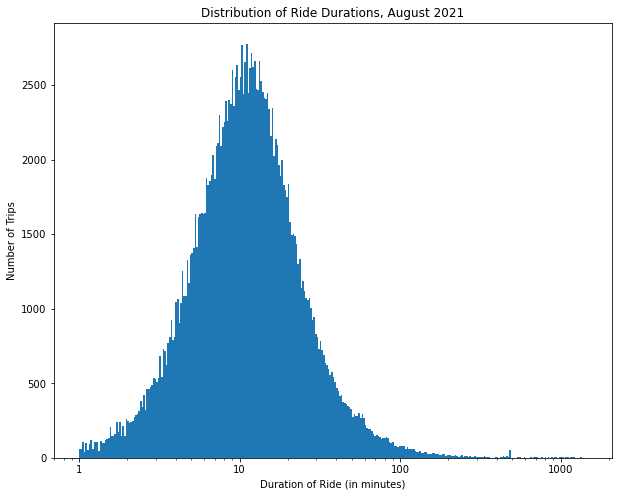

In [21]:
log_binsize = 0.01
log_bins = 10 ** np.arange(0, np.log10(df_clean['ride_duration'].max()) + log_binsize, log_binsize)

plt.figure(figsize=[10, 8])
plt.hist(data = df_clean, x = 'ride_duration', bins = log_bins)
plt.title('Distribution of Ride Durations, August 2021')
plt.xlabel('Duration of Ride (in minutes)')
plt.ylabel('Number of Trips')
plt.xscale('log')
plt.xticks([1, 10, 1e2, 1e3],[1, 10, 100, 1000])
plt.show()

## Number of Rides Per Day, August 2021

> This line chart shows that in August 2021, overall ridership tended to dip on Mondays and peak on Saturdays.


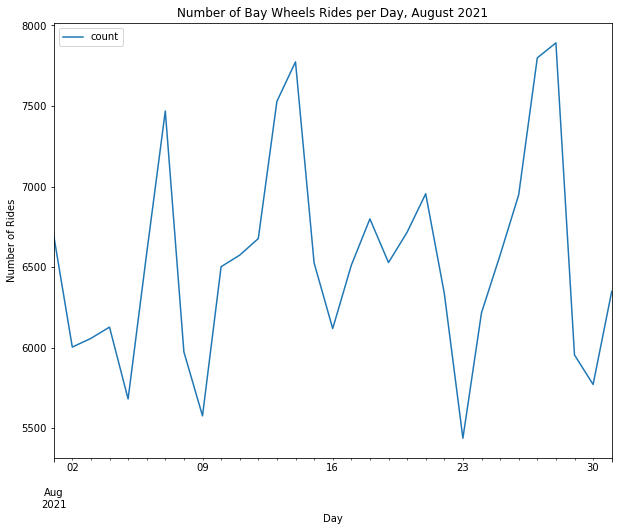

In [22]:
plt.rcParams["figure.figsize"] = [10,8]

test = df_clean["started_at"].groupby(df_clean["started_at"].dt.floor('d')).size().reset_index(name='count')
test.plot(x='started_at',y='count', kind="line")
plt.title("Number of Bay Wheels Rides per Day, August 2021")
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.show();

## Number of Rides Per Day by Rider Type, August 2021

> This line chart shows that in August 2021, casual riders tended to ride on Friday, Saturday and Sunday, while member riders tended to ride on weekdays.

In [23]:
test1 = df_clean["started_at"].groupby([df_clean["started_at"].dt.floor('d'), df_clean["rider_type"]]).size().reset_index(name='count')
test1["date"] = test1["started_at"].dt.strftime('%a %d')


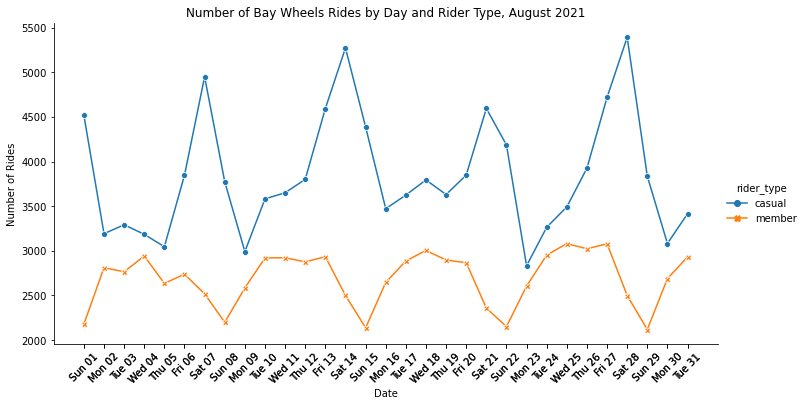

In [24]:
#create a line chart with showing the number of rides per day by rider type
ax=sns.relplot(x="date", y="count", 
            data=test1, kind="line", 
            ci=None, style="rider_type", 
            hue="rider_type",
            markers=True,
            dashes=False, height=5, aspect = 2)
plt.title("Number of Bay Wheels Rides by Day and Rider Type, August 2021")
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(test1["date"], rotation=45);

## Number of Rides Per Day by Bike Type, August 2021

> This line chart shows that in August 2021, ridership of both electric and classic bikes tended to peak over the weekend (Saturday) and dip on Monday. The number of rides on docked bikes was much lower, and tended to stay flat.

In [25]:
#create a dataframe that contains the day of the week and date from started_at and is grouped by bike type
test2 = df_clean["started_at"].groupby([df_clean["started_at"].dt.floor('d'), df_clean["bike_type"]]).size().reset_index(name='count')

test2["date"] = test2["started_at"].dt.strftime('%a %d')


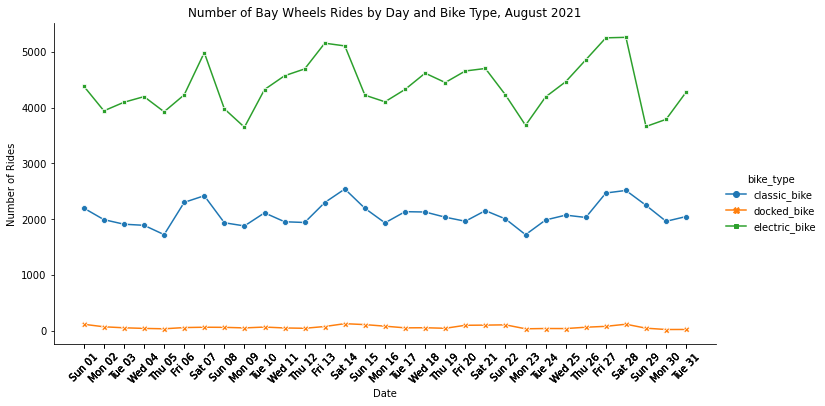

In [26]:
#create a line chart with showing the number of rides per day by bike type
ax=sns.relplot(x="date", y="count", 
            data=test2, kind="line", 
            ci=None, style="bike_type", 
            hue="bike_type",
            markers=True,
            dashes=False, height=5, aspect = 2)
plt.title("Number of Bay Wheels Rides by Day and Bike Type, August 2021")
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(test2["date"], rotation=45);

## Mean Ride Duration in Minutes by Day of the Week and Rider Type, August 2021
> This bar chart shows that the average (mean) ride duration by casual riders is greater than the average (mean) ride duration of member riders, both on weekdays and weekends. Mean ride duration for member rides is less than 15 minutes.

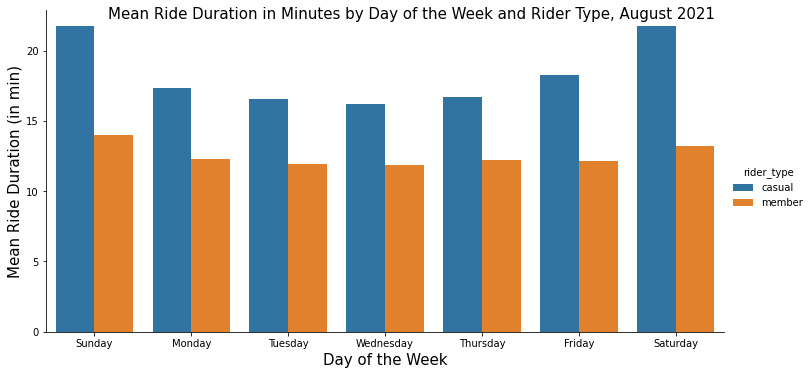

In [28]:
chart = sns.catplot(x="start_dayofweek", y = "ride_duration", kind="bar", hue = "rider_type", data=df_clean, height=5, aspect=2, ci=None);
chart.fig.suptitle("Mean Ride Duration in Minutes by Day of the Week and Rider Type, August 2021", fontsize=15)
chart.set_xlabels('Day of the Week', fontsize=15) 
chart.set_ylabels('Mean Ride Duration (in min)', fontsize=15)
plt.show();